# Setup

Imports:

In [29]:
from dataclasses import dataclass
import random
import matplotlib.pyplot as plt

### Defining classes

* **Node** <br>
  Every person in the simulation is a node.
  * `neighbors`: a list of all of the Node's neighbors, which are also Nodes.
  * `degree()`: returns the number of neighbors the Node has -- its "degree".

* **Graph** <br>
  A class for all of the graphs. <br>
  Contains a list of the Nodes in the graph. <br>
  For example in this case we will have one "Icelandic" Graph and one "English" Graph.
  * `nodes`: a list of all of the Nodes in this Graph.
  * `create_edge`: gets two nodes. If they are both in the graph and are not already neighbors, each one is added to the other's list of neighbors, thus creating an edge between them.

In [30]:
class Node:
    def __init__(self):
        self.neighbors: list["Node"] = []
        self.friend_group: float = random.random()
        self.frequency: float = 0
        
    def __repr__(self):
        return f"Node[deg={len(self.neighbors)}, freq={self.frequency:.3f}]"
    
    def degree(self) -> int:
        return len(self.neighbors)
    

class Graph:
    def __init__(self):
        self.nodes: list[Node] = []
    
    def __str__(self) -> str:
        return str(self.nodes)

    def create_edge(self, node1: Node, node2: Node) -> None:
        if node1 not in self.nodes or node2 not in self.nodes:
            raise ValueError("Node not in Graph")
        if node1 in node2.neighbors or node2 in node1.neighbors:
            raise ValueError("Edge already exists")
        node1.neighbors.append(node2)
        node2.neighbors.append(node1)


### Creating Graph

This function gets the following parameters:
* `node_num`: the number of Nodes that are going to be in the Graph.
* `edge_prob`: the probability two random nodes would have an edge between them.
And returns a Graph.

`friendliness`: The difference between the friend group of `g.nodes[i]` and `g.nodes[j]`, i.e. the two nodes we want to connect.

Every iteration, the function creates a node, then goes over all of the nodes that were already created (this way the same pair of nodes will not occur twice). After going through the probability check, it creates an edge between the two nodes using `create_edge`.

**TODO**: not sure how to confirm that the friendliness probability check works

**TODO**: the friendliness thing makes it much more probable to have an edge between two nodes (because it is added to `edge_prob`). That means if `edge_prob` is 0.5 and `node_num` is 100, the average number of neighbors for each node will be around 78, while before the friendliness addition it would have been 50. Not really sure if that's a problem, and if it is how to solve it.



In [31]:
def create_graph_simple(node_num: int, edge_prob: float) -> Graph:
    g = Graph()
    for i in range(node_num):
        g.nodes.append(Node())
        for j in range(len(g.nodes)-1):
            if random.random() < edge_prob:
                g.create_edge(g.nodes[i], g.nodes[j])
    return g

In [32]:
def create_graph_w_friend(node_num: int, edge_prob: float) -> Graph:
    g = Graph()
    for i in range(node_num):
        g.nodes.append(Node())
        for j in range(len(g.nodes)-1):
            friendliness = abs(g.nodes[i].friend_group - g.nodes[j].friend_group)
            if random.random() < edge_prob + friendliness:
                g.create_edge(g.nodes[i], g.nodes[j])
    return g

Testing:

In [33]:
NUM_NODES = 100
a = create_graph_simple(NUM_NODES, 0.5)
total = 0
for n in a.nodes:
    total += n.degree()
print(a)
print(total/NUM_NODES)

[Node[deg=50, freq=0.000], Node[deg=53, freq=0.000], Node[deg=48, freq=0.000], Node[deg=53, freq=0.000], Node[deg=54, freq=0.000], Node[deg=52, freq=0.000], Node[deg=51, freq=0.000], Node[deg=47, freq=0.000], Node[deg=47, freq=0.000], Node[deg=48, freq=0.000], Node[deg=46, freq=0.000], Node[deg=41, freq=0.000], Node[deg=55, freq=0.000], Node[deg=52, freq=0.000], Node[deg=50, freq=0.000], Node[deg=56, freq=0.000], Node[deg=46, freq=0.000], Node[deg=49, freq=0.000], Node[deg=46, freq=0.000], Node[deg=47, freq=0.000], Node[deg=49, freq=0.000], Node[deg=44, freq=0.000], Node[deg=47, freq=0.000], Node[deg=49, freq=0.000], Node[deg=57, freq=0.000], Node[deg=56, freq=0.000], Node[deg=54, freq=0.000], Node[deg=52, freq=0.000], Node[deg=42, freq=0.000], Node[deg=49, freq=0.000], Node[deg=44, freq=0.000], Node[deg=55, freq=0.000], Node[deg=48, freq=0.000], Node[deg=53, freq=0.000], Node[deg=48, freq=0.000], Node[deg=49, freq=0.000], Node[deg=48, freq=0.000], Node[deg=55, freq=0.000], Node[deg=51

### Timestep Function


TODO: here should be a function that will be run every timestep. It will include two for loops that go over all nodes in the graph: in the first one it will put into a dictionary the position of the current node in the list of nodes, which will lead to its new frequency. In the second one it will go over the dictionary and update the frequencies.

In [34]:
def step_rule_follow_random_neighbor(node: Node) -> float:
    if len(node.neighbors) == 0:
        return node.frequency
    return random.choice(node.neighbors).frequency

In [35]:
def run_timestep(g: Graph) -> None:
    # Goes through all of the nodes in the graph and adds it to a dictionary, pointing at its soon-to-be frequency.
    # Then goes through all of the nodes again.
    # Has to go through all of them twice so that the function step_rule will consider only the old frequencies and not the new ones. 
    d: dict[Node, float] = {}
    for node in g.nodes:
        d[node] = step_rule_follow_random_neighbor(node)
    for node, freq in d.items():
        node.frequency = freq

# Main

In [62]:
g = create_graph_simple(100, 0.05)
for node in g.nodes:
    if random.random() < 0.5:
        node.frequency = random.random()
    # else: it will be zero

avg_list = []
for i in range(500):
    run_timestep(g)
    avg_list.append(sum([node.frequency for node in g.nodes])/len(g.nodes))

print(g)

[Node[deg=4, freq=0.904], Node[deg=5, freq=0.904], Node[deg=4, freq=0.904], Node[deg=1, freq=0.904], Node[deg=4, freq=0.904], Node[deg=6, freq=0.904], Node[deg=2, freq=0.904], Node[deg=5, freq=0.904], Node[deg=6, freq=0.904], Node[deg=3, freq=0.904], Node[deg=4, freq=0.904], Node[deg=3, freq=0.904], Node[deg=11, freq=0.904], Node[deg=4, freq=0.904], Node[deg=4, freq=0.904], Node[deg=4, freq=0.904], Node[deg=4, freq=0.904], Node[deg=0, freq=0.000], Node[deg=4, freq=0.904], Node[deg=2, freq=0.904], Node[deg=7, freq=0.904], Node[deg=3, freq=0.904], Node[deg=1, freq=0.904], Node[deg=5, freq=0.904], Node[deg=3, freq=0.904], Node[deg=5, freq=0.904], Node[deg=2, freq=0.904], Node[deg=5, freq=0.904], Node[deg=5, freq=0.904], Node[deg=1, freq=0.904], Node[deg=3, freq=0.904], Node[deg=6, freq=0.904], Node[deg=1, freq=0.904], Node[deg=5, freq=0.904], Node[deg=3, freq=0.904], Node[deg=2, freq=0.904], Node[deg=4, freq=0.904], Node[deg=6, freq=0.904], Node[deg=4, freq=0.904], Node[deg=8, freq=0.904]

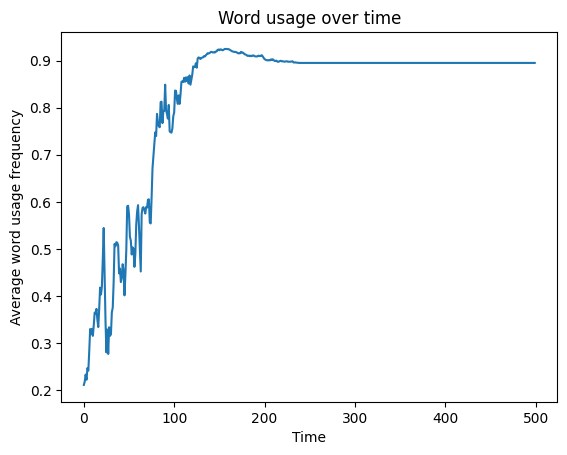

In [63]:
plt.plot(avg_list)
plt.xlabel('Time')
plt.ylabel('Average word usage frequency')
plt.title('Word usage over time')
plt.show()